# Tâche 3 — OCR & Détection de Fraude (Documents d'identité)

## 1. Introduction & Objectifs
- Objectif : extraire le texte (OCR) et classifier le document (`normal` / `forgery_1..4`).
- Données : `data/train` (>10k docs, 4 pays), structure par pays :
  - `normal/` (images originales)
  - `gt/` (JSON ground truth champs texte)
  - `forgery_1..4/` (versions falsifiées)
- Test : 200 images réparties équitablement.
- Livrables :
  - `results/ocr_fraud/ocr_fraud_predictions.csv` (colonnes `image_id,class`)
  - `models/ocr_fraud/ocr_fraud_best.pth`
  - Notebook complet (ce fichier)

## 2. Chargement des librairies & Configuration
- Import des librairies
- Lecture du fichier de config : `src/utils/config_t3.yaml`

In [50]:
# === Rendre src importable depuis notebooks/ ===
import os, sys
sys.path.insert(0, os.path.abspath(".."))

# === Config YAML ===
import yaml
with open("../src/utils/config_t3.yaml") as f:
    config = yaml.safe_load(f)

# === Imports modèle + réglage Tesseract (Mac M1/M2/M3 Homebrew) ===
from src.models import OCRFraudNet
import pytesseract

# Si besoin, décommente la ligne suivante si pytesseract ne trouve pas tesseract automatiquement
# pytesseract.pytesseract.tesseract_cmd = "/opt/homebrew/bin/tesseract"

print("Configuration Tâche 3 chargée ✅")
print("OCRFraudNet importé ✅")

Configuration Tâche 3 chargée ✅
OCRFraudNet importé ✅


## 3. Exploration du dataset
- Comptage par pays et par classe (`normal`, `forgery_1..4`)
- Exemples d’images (floutées si besoin pour la présentation)

In [44]:
import os
import json
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class OCRDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        classes = ["normal", "forgery_1", "forgery_2", "forgery_3", "forgery_4"]

        for cls in classes:
            cls_dir = os.path.join(root_dir, cls)
            if os.path.exists(cls_dir):
                for fname in os.listdir(cls_dir):
                    if fname.endswith(".png") or fname.endswith(".jpg"):
                        self.samples.append((cls, fname))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        cls, fname = self.samples[idx]
        img_path = os.path.join(self.root_dir, cls, fname)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = cls
        return image, label


# Configuration DataLoader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_loader_t3 = DataLoader(
    OCRDataset("../data/tache3/train/arizona_dl", transform=transform),
    batch_size=4,
    shuffle=True
)

test_loader_t3 = DataLoader(
    OCRDataset("../data/tache3/test/arizona_dl", transform=transform),
    batch_size=4,
    shuffle=False
)

## 4. OCR multilingue & Extraction des champs
- Correction de perspective, binarisation, débruitage
- Langues Tesseract ciblées : eng, spa, est, rus
- Paramétrage Tesseract (PSM, OEM)
- Comparaison OCR vs `gt/*.json` (exactitude par champ)

In [45]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Dataset personnalisé qui parcourt: val/OU train/ -> pays -> classes (normal, forgery_1..4)
class FraudDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        # root_dir: ../data/tache3/train  ou  ../data/tache3/val
        for country in os.listdir(root_dir):
            c_path = os.path.join(root_dir, country)
            if not os.path.isdir(c_path):
                continue

            for cls in os.listdir(c_path):
                cls_path = os.path.join(c_path, cls)
                if not os.path.isdir(cls_path) or cls == "gt":
                    continue  # ignore les JSON

                for fname in os.listdir(cls_path):
                    if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                        self.samples.append((os.path.join(cls_path, fname), cls))

        # mapping classes
        classes = sorted({cls for _, cls in self.samples})
        self.class_to_idx = {cls: i for i, cls in enumerate(classes)}
        self.idx_to_class = {i: cls for cls, i in self.class_to_idx.items()}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, cls = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.class_to_idx[cls], dtype=torch.long)
        return img, label

# ---- transforms (tu peux mettre 224x224 pour l'entraînement final) ----
train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
val_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ---- chemins depuis le notebook ----
TRAIN_DIR = "../" + config["paths"]["train_dir"]   # ../data/tache3/train
VAL_DIR   = "../" + config["paths"]["val_dir"]     # ../data/tache3/val

train_ds = FraudDataset(TRAIN_DIR, transform=train_tf)
val_ds   = FraudDataset(VAL_DIR,   transform=val_tf)

train_loader_t3 = DataLoader(train_ds,
    batch_size=config["training"]["batch_size"],
    shuffle=True,
    num_workers=0
)
val_loader_t3 = DataLoader(val_ds,
    batch_size=config["training"]["batch_size"],
    shuffle=False,
    num_workers=0
)

print("Classes détectées:", train_ds.class_to_idx)
print("n_train:", len(train_ds), "| n_val:", len(val_ds))


Classes détectées: {'forgery_1': 0, 'forgery_2': 1, 'forgery_3': 2, 'forgery_4': 3, 'normal': 4}
n_train: 10000 | n_val: 1000


## 5. Dataset Fraude & DataLoader (PyTorch)
- Construction dataset de classification (image → classe)
- Paramètres : batch_size, seed

In [46]:
from src.models.ocr_fraud_model import OCRFraudNet
import torch

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("✅ Device utilisé :", device)

# Instancier le modèle avec le bon nombre de classes
num_classes = len(train_ds.class_to_idx)  # issu du Step 5
model = OCRFraudNet(num_classes=num_classes).to(device)

print("✅ OCRFraudNet importé et instancié avec", num_classes, "classes")


✅ Device utilisé : mps
✅ OCRFraudNet importé et instancié avec 5 classes


## 6. Modèle de Détection de Fraude
- CNN/Transformer pour classification `normal`/`forgery_1..4`
- Sauvegarde des poids dans `models/ocr_fraud/`

In [17]:
import torch.optim as optim

# Perte + Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"])

# Fonctions utilitaires
def train_one_epoch(loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / max(1, len(loader))

@torch.no_grad()
def evaluate(loader, model, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total if total else 0
    return total_loss / max(1, len(loader)), acc

# Boucle d'entraînement
best_acc = 0.0
num_epochs = int(config["training"]["epochs"])

for epoch in range(num_epochs):
    train_loss = train_one_epoch(train_loader_t3, model, criterion, optimizer, device)
    val_loss, val_acc = evaluate(val_loader_t3, model, criterion, device)

    print(f"[Epoch {epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        os.makedirs("../" + config["paths"]["output_models"], exist_ok=True)
        torch.save(model.state_dict(), "../" + config["paths"]["output_models"] + "/best.pth")
        print("💾 ✅ Meilleur modèle sauvegardé !")


[Epoch 1/5] Train Loss: 1.2646 | Val Loss: 0.8676 | Val Acc: 0.5890
💾 ✅ Meilleur modèle sauvegardé !
[Epoch 2/5] Train Loss: 0.6774 | Val Loss: 0.5675 | Val Acc: 0.6980
💾 ✅ Meilleur modèle sauvegardé !
[Epoch 3/5] Train Loss: 0.6000 | Val Loss: 0.5477 | Val Acc: 0.7250
💾 ✅ Meilleur modèle sauvegardé !
[Epoch 4/5] Train Loss: 0.5450 | Val Loss: 0.4511 | Val Acc: 0.7800
💾 ✅ Meilleur modèle sauvegardé !
[Epoch 5/5] Train Loss: 0.4798 | Val Loss: 0.3858 | Val Acc: 0.8330
💾 ✅ Meilleur modèle sauvegardé !


## 7. Entraînement
- Journal des métriques par epoch
- Gestion déséquilibre (pondération éventuelle)

In [58]:
import os
import pandas as pd
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch

# === Charger modèle ===
from src.models.ocr_fraud_model import OCRFraudNet

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

num_classes = 5  # normal, forgery_1..4
model = OCRFraudNet(num_classes=num_classes).to(device)

# Charger les poids sauvegardés
best_model_path = "../" + config["paths"]["output_models"] + "/best.pth"
state_dict = torch.load(best_model_path, map_location=device)
new_state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict, strict=False)
model.eval()
print("✅ Modèle OCRFraudNet chargé pour validation")

# === Custom Dataset qui descend d’un niveau (val/pays/classe/img) ===
class ValDataset(Dataset):
    def __init__(self, root, transform=None):
        self.samples = []
        self.transform = transform
        for country in os.listdir(root):
            c_path = os.path.join(root, country)
            if not os.path.isdir(c_path): continue
            for class_name in os.listdir(c_path):
                class_path = os.path.join(c_path, class_name)
                if not os.path.isdir(class_path): continue
                for fname in os.listdir(class_path):
                    if fname.lower().endswith((".png",".jpg",".jpeg")):
                        self.samples.append((os.path.join(class_path, fname), class_name))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, label, path

val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_ds = ValDataset("../data/tache3/val", transform=val_tf)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

print(f"📊 Nb images validation: {len(val_ds)}")

# === Inférence ===
results = []
idx_to_class = {0:"normal", 1:"forgery_1", 2:"forgery_2", 3:"forgery_3", 4:"forgery_4"}

with torch.no_grad():
    for imgs, labels, paths in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()

        for true, pred, path in zip(labels, preds, paths):
            results.append({
                "image": os.path.relpath(path, "../data/tache3/val"),
                "label": true,                 # string (ex: forgery_2)
                "prediction": idx_to_class[pred]  # modèle
            })

# === Sauvegarde CSV ===
OUTPUT_DIR = "../" + config["paths"]["output_results"]
os.makedirs(OUTPUT_DIR, exist_ok=True)

csv_path = os.path.join(OUTPUT_DIR, "val_predictions.csv")
pd.DataFrame(results).to_csv(csv_path, index=False)

print("✅ Prédictions validation sauvegardées dans:", csv_path)

✅ Modèle OCRFraudNet chargé pour validation
📊 Nb images validation: 1000
✅ Prédictions validation sauvegardées dans: ../results/ocr_fraud/val_predictions.csv


## 8. Évaluation (Validation)
- Métriques : accuracy, precision, recall, F1 (macro)
- Rapport par pays & par type de fraude
- Tableau d’exactitude OCR par champ

✅ Accuracy globale : 0.2240

📊 Rapport de classification :
              precision    recall  f1-score   support

      normal       0.33      0.02      0.04       200
   forgery_1       0.22      0.20      0.21       200
   forgery_2       0.22      0.53      0.31       200
   forgery_3       0.23      0.37      0.29       200
   forgery_4       0.00      0.00      0.00       200

    accuracy                           0.22      1000
   macro avg       0.20      0.22      0.17      1000
weighted avg       0.20      0.22      0.17      1000



/Users/evanszigui/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/evanszigui/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/evanszigui/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

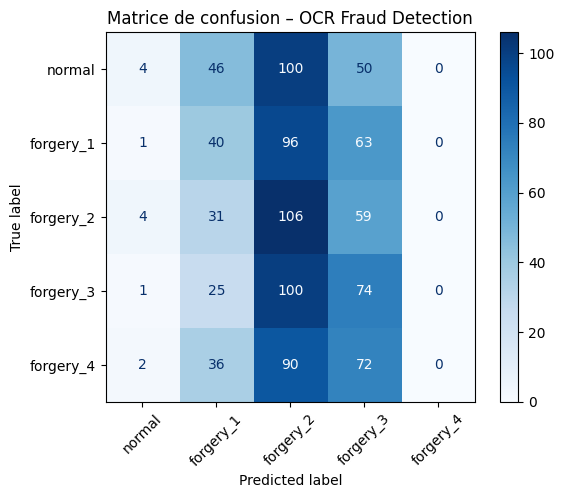

In [59]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Charger résultats validation
val_csv = "../results/ocr_fraud/val_predictions.csv"
df = pd.read_csv(val_csv)

y_true = df["label"]
y_pred = df["prediction"]

# === Accuracy globale ===
acc = accuracy_score(y_true, y_pred)
print(f"✅ Accuracy globale : {acc:.4f}")

# === Rapport détaillé (precision, recall, F1 par classe) ===
print("\n📊 Rapport de classification :")
print(classification_report(y_true, y_pred, labels=["normal","forgery_1","forgery_2","forgery_3","forgery_4"]))

# === Matrice de confusion ===
cm = confusion_matrix(y_true, y_pred, labels=["normal","forgery_1","forgery_2","forgery_3","forgery_4"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["normal","forgery_1","forgery_2","forgery_3","forgery_4"])
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Matrice de confusion – OCR Fraud Detection")
plt.show()


## 9. Inférence sur Test
- Générer `results/ocr_fraud/ocr_fraud_predictions.csv`
- Colonnes : `image_id,class` (classes exactes : `normal, forgery_1, forgery_2, forgery_3, forgery_4`)

In [52]:
import os
import pandas as pd
from torchvision import transforms
from PIL import Image
import torch

# === Charger modèle ===
from src.models.ocr_fraud_model import OCRFraudNet

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

num_classes = 5  # normal, forgery_1..4
model = OCRFraudNet(num_classes=num_classes).to(device)

# === Charger les poids sauvegardés (fix des clés "backbone.") ===
best_model_path = "../" + config["paths"]["output_models"] + "/best.pth"

state_dict = torch.load(best_model_path, map_location=device)
new_state_dict = {}
for k, v in state_dict.items():
    # Supprimer le préfixe "backbone." si présent
    new_key = k.replace("backbone.", "")
    new_state_dict[new_key] = v

# Charger avec tolérance (strict=False)
model.load_state_dict(new_state_dict, strict=False)
model.eval()
print("✅ Modèle OCRFraudNet chargé pour inférence")

# === Préparer le dossier test ===
TEST_DIR = "../data/tache3/test"

test_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

results = []

# Parcourir toutes les images du dossier test, récursivement
with torch.no_grad():
    for root, _, files in os.walk(TEST_DIR):
        for fname in files:
            if fname.lower().endswith((".png",".jpg",".jpeg")):
                img_path = os.path.join(root, fname)
                img = Image.open(img_path).convert("RGB")
                img = test_tf(img).unsqueeze(0).to(device)

                outputs = model(img)
                pred = outputs.argmax(dim=1).item()

                # Mapping indices → classes
                idx_to_class = {0: "normal",1: "forgery_1",2: "forgery_2",3: "forgery_3",4: "forgery_4"}
                pred_class = idx_to_class[pred]

                results.append({
                    "image": os.path.relpath(img_path, TEST_DIR),  # chemin relatif
                    "prediction": pred_class
                })

# === Sauvegarder en CSV ===
OUTPUT_DIR = "../" + config["paths"]["output_results"]
os.makedirs(OUTPUT_DIR, exist_ok=True)

csv_path = os.path.join(OUTPUT_DIR, "predictions.csv")
pd.DataFrame(results).to_csv(csv_path, index=False)

print("✅ Prédictions terminées. Résultats sauvegardés dans:", csv_path)

# Vérifier un extrait
print("\nAperçu des prédictions :")
print(pd.DataFrame(results).head())


✅ Modèle OCRFraudNet chargé pour inférence
✅ Prédictions terminées. Résultats sauvegardés dans: ../results/ocr_fraud/predictions.csv

Aperçu des prédictions :
                                               image prediction
0  esp/generated.photos_v3_0075573_0131493_000151...  forgery_2
1                esp/generated.photos_v3_0075411.png  forgery_1
2  esp/generated.photos_v3_0072572_0465277_098338...  forgery_1
3  esp/generated.photos_v3_0072572_0465277_028600...  forgery_2
4  esp/generated.photos_v3_0075573_0131493_035403...  forgery_1
